In [1]:
!pip install pandas_datareader
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 6.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame, impute

import pandas_datareader.data as web

from sklearn.linear_model import LinearRegression

In [4]:
df = web.DataReader("IBM", 'stooq')['Close']
df.head()

Date
2024-07-10    177.84
2024-07-09    176.48
2024-07-08    177.64
2024-07-05    176.02
2024-07-03    175.73
Name: Close, dtype: float64

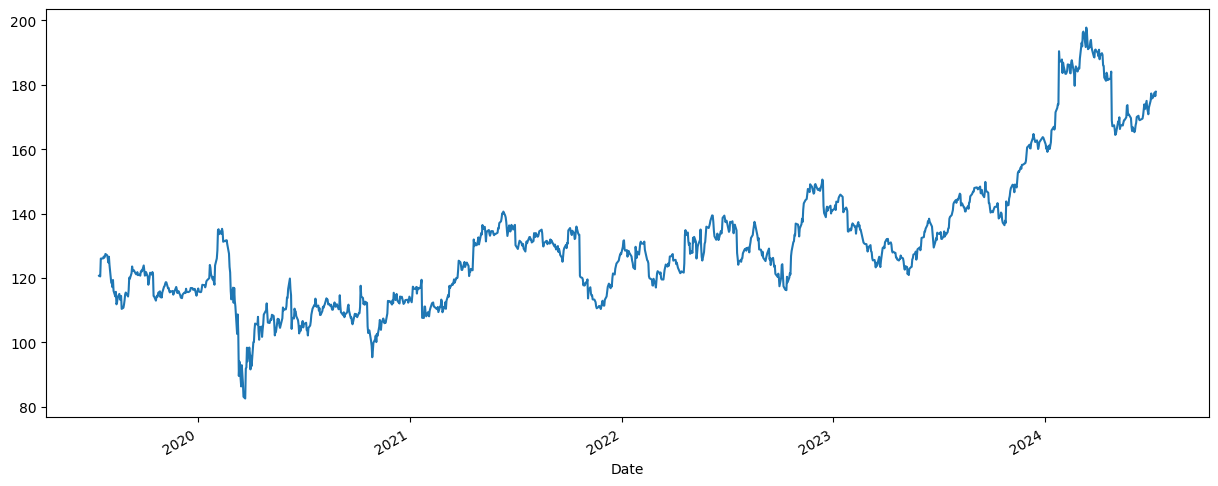

In [7]:
df.plot(figsize=(15, 6))
plt.show()

In [11]:
df_melted = pd.DataFrame({"close": df.copy()})
df_melted["date"] = df_melted.index
df_melted["symbols"] = "IBM"

In [257]:
df_melted_train = df_melted[df_melted.index.year < 2023]
df_melted_test = df_melted

In [258]:
df_melted_test

,close,date,symbols
Date,,,
2024-07-10,177.840,2024-07-10,IBM
2024-07-09,176.480,2024-07-09,IBM
2024-07-08,177.640,2024-07-08,IBM
2024-07-05,176.020,2024-07-05,IBM
2024-07-03,175.730,2024-07-03,IBM
...,...,...,...
2019-07-19,126.030,2019-07-19,IBM
2019-07-18,126.002,2019-07-18,IBM
2019-07-17,120.458,2019-07-17,IBM


In [259]:
df_rolled_train = roll_time_series(df_melted_train, column_id="symbols", column_sort="date",
                             max_timeshift=10, min_timeshift=5)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 875/875 [00:02<00:00, 357.16it/s]


In [260]:
df_rolled_test = roll_time_series(df_melted_test, column_id="symbols", column_sort="date",
                             max_timeshift=10, min_timeshift=5)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 1256/1256 [00:04<00:00, 294.45it/s]


In [261]:
X_train = extract_features(df_rolled_train.drop("symbols", axis=1),
                     column_id="id", column_sort="date", column_value="close",
                     impute_function=impute, show_warnings=False)
X_train = X_train.set_index(X_train.index.map(lambda x: x[1]), drop=True)
X_train.index.name = "last_date"

Feature Extraction: 100%|██████████| 870/870 [01:01<00:00, 14.13it/s]


In [264]:
X_test = extract_features(df_rolled_test.drop("symbols", axis=1),
                     column_id="id", column_sort="date", column_value="close",
                     impute_function=impute, show_warnings=False)
X_test = X_test.set_index(X_test.index.map(lambda x: x[1]), drop=True)
X_test.index.name = "last_date"

Feature Extraction: 100%|██████████| 1251/1251 [01:33<00:00, 13.38it/s]


In [265]:
X_test = X_test[X_test.index.year >= 2023]

In [266]:
y = df_melted.set_index("date").sort_index().close.shift(-1)
y_train = y[y.index.isin(X_train.index)]
y_test = y[y.index.isin(X_test.index)]

In [272]:
y_train

date
2019-07-22    126.635
2019-07-23    126.304
2019-07-24    126.635
2019-07-25    127.436
2019-07-26    127.017
               ...   
2022-12-23    142.420
2022-12-27    140.020
2022-12-28    141.060
2022-12-29    140.890
2022-12-30    141.550
Name: close, Length: 870, dtype: float64

In [268]:
X_train_selected = select_features(X_train, y_train)

In [269]:
lr = LinearRegression()
lr.fit(X_train_selected, y_train)

LinearRegression()

In [270]:
X_test_selected = X_test[X_train_selected.columns]
y_pred = pd.Series(lr.predict(X_test_selected), index=X_test_selected.index)

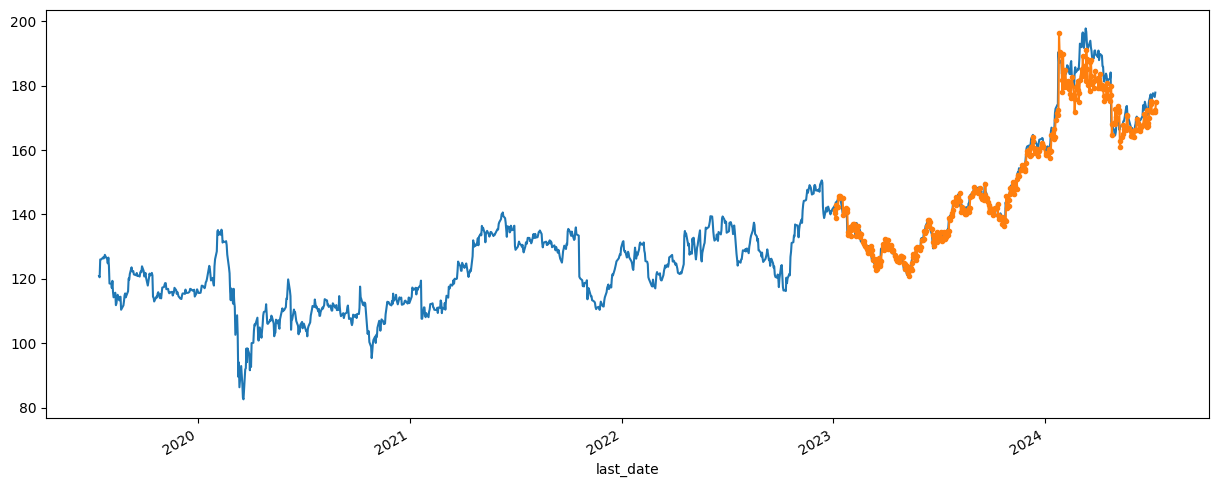

In [271]:
plt.figure(figsize=(15, 6))
y.plot()
y_pred.plot(legend=None, marker=".")
plt.show()